In [1]:
%reload_ext autoreload
%autoreload 2
#%reload_ext notexbook'
#%texify

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/notebooks')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5

In [3]:
param_file = '../cellbgnet/utils/reference_files/reference_Axel.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)

In [4]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']

In [5]:
psf_size = 41
xextent = [-0.5, 127.5]
yextent = [-0.5, 127.5]
zextent = [-400, 400]
scale = torch.tensor([(xextent[1] - xextent[0]),
                      (yextent[1] - yextent[0]),
                      (zextent[1] - zextent[0])])
shift = torch.tensor([xextent[0], yextent[0], zextent[0]])

In [12]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cuda', 
roi_size=None, roi_auto_center=None, normalize=True)
psf_cpu = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
roi_size=None, roi_auto_center=None, normalize=True)

INITIATING CUDA IMPLEMENTATION
INITIATING CPU IMPLEMENTATION


In [7]:
import random

n_per_frame = 2
xyz = (torch.tensor([random.uniform(0, 128), random.uniform(0, 128), -500])).view(-1, 3)
xyz = xyz.repeat(n_per_frame,1)

photon_scale = 3000
photons = torch.rand((xyz.shape[0], n_per_frame))*photon_scale


In [8]:
photon_scale =3000
column1 = torch.repeat_interleave(torch.tensor([20, 60, 100]), 3, 0).view(-1, 1)
column2 = torch.tensor([20, 60, 100]).repeat(1, 3).view(-1, 1)
column3 = (torch.rand(column1.shape[0]).view(-1, 1)-0.5)*1000
xyz = torch.concat((column1, column2, column3), dim=1)
photons = torch.rand((xyz.shape[0], 9))*photon_scale
xyz

tensor([[  20.0000,   20.0000,   50.6086],
        [  20.0000,   60.0000,  281.2615],
        [  20.0000,  100.0000,  402.2051],
        [  60.0000,   20.0000, -272.4926],
        [  60.0000,   60.0000,  -45.3999],
        [  60.0000,  100.0000,  478.8575],
        [ 100.0000,   20.0000, -302.6746],
        [ 100.0000,   60.0000, -467.2666],
        [ 100.0000,  100.0000, -252.3637]])

In [13]:
import time
start = time.time()
n = 100
diffs = []
msqes = []
gt_phot = []
gt_z = []
gt_x = []
gt_y = []
photon_scale =3000

for i in range(n):
    #offset = float(np.random.uniform(-0.5, 0.5, 1))
    column1 = torch.repeat_interleave(torch.tensor([20, 60, 100]), 3, 0).view(-1, 1)
    column2 = torch.tensor([20, 60, 100]).repeat(1, 3).view(-1, 1)
    column3 = (torch.rand(column1.shape[0]).view(-1, 1)-0.5)*1000
    xyz = torch.concat((column1, column2, column3), dim=1)
    photons = torch.rand((xyz.shape[0], 1))*photon_scale
    im = psf.forward(xyz, photons)
    im_cpu = psf_cpu.forward(xyz, photons)
    for j in range(xyz.shape[0]):
        x_val = int(xyz[j,0].item())
        y_val = int(xyz[j,1].item())
        z_val = int(xyz[j,2].item())
        roi_cuda = im[0,x_val-20:x_val+20, y_val-20:y_val+20]
        roi_cpu = im_cpu[0,x_val-20:x_val+20, y_val-20:y_val+20]
        diff = (roi_cuda.sum() - photons[j])/photons[j]
        diffs.append(diff)
        msqe = ((roi_cuda - roi_cpu)**2).mean()
        msqes.append(msqe)
        gt_phot.append(photons[j])
        gt_x.append(x_val)
        gt_y.append(y_val)
        gt_z.append(z_val)
        """"if abs(msqe) > 0.01:
            print(z_val, msqe)
            plt.imshow(roi_cuda)
            plt.title('CUDA')
            plt.show()
            plt.imshow(roi_cpu)
            plt.title('CPU')
            plt.show()"""





end = time.time() 
print(f'time: {1000*(end-start)/(n*9):.3f} ms')



time: 0.267 ms


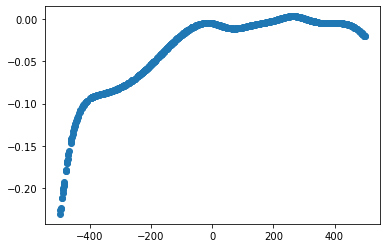

In [14]:
plt.plot(gt_z, diffs, 'o')


In [29]:
(np.absolute(np.array(diffs)) > 0.03).mean()



0.0

In [43]:
for k in range(64):
    print(f'{k:{2}}: {k//16},  {(k%16)//4}, {k%4}' , end=' | ')
    if (k%4 == 3) and (k!= 0):
        print()

 0: 0,  0, 0 |  1: 0,  0, 1 |  2: 0,  0, 2 |  3: 0,  0, 3 | 
 4: 0,  1, 0 |  5: 0,  1, 1 |  6: 0,  1, 2 |  7: 0,  1, 3 | 
 8: 0,  2, 0 |  9: 0,  2, 1 | 10: 0,  2, 2 | 11: 0,  2, 3 | 
12: 0,  3, 0 | 13: 0,  3, 1 | 14: 0,  3, 2 | 15: 0,  3, 3 | 
16: 1,  0, 0 | 17: 1,  0, 1 | 18: 1,  0, 2 | 19: 1,  0, 3 | 
20: 1,  1, 0 | 21: 1,  1, 1 | 22: 1,  1, 2 | 23: 1,  1, 3 | 
24: 1,  2, 0 | 25: 1,  2, 1 | 26: 1,  2, 2 | 27: 1,  2, 3 | 
28: 1,  3, 0 | 29: 1,  3, 1 | 30: 1,  3, 2 | 31: 1,  3, 3 | 
32: 2,  0, 0 | 33: 2,  0, 1 | 34: 2,  0, 2 | 35: 2,  0, 3 | 
36: 2,  1, 0 | 37: 2,  1, 1 | 38: 2,  1, 2 | 39: 2,  1, 3 | 
40: 2,  2, 0 | 41: 2,  2, 1 | 42: 2,  2, 2 | 43: 2,  2, 3 | 
44: 2,  3, 0 | 45: 2,  3, 1 | 46: 2,  3, 2 | 47: 2,  3, 3 | 
48: 3,  0, 0 | 49: 3,  0, 1 | 50: 3,  0, 2 | 51: 3,  0, 3 | 
52: 3,  1, 0 | 53: 3,  1, 1 | 54: 3,  1, 2 | 55: 3,  1, 3 | 
56: 3,  2, 0 | 57: 3,  2, 1 | 58: 3,  2, 2 | 59: 3,  2, 3 | 
60: 3,  3, 0 | 61: 3,  3, 1 | 62: 3,  3, 2 | 63: 3,  3, 3 | 


In [16]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cuda', 
roi_size=None, roi_auto_center=None, normalize=True)


INITIATING CUDA IMPLEMENTATION


In [17]:

import time
n = 10000
n_per_frame = 100
photon_scale =3000
#column1 = torch.repeat_interleave(torch.tensor([20, 60, 100]), 3, 0).view(-1, 1)
#column2 = torch.tensor([20, 60, 100]).repeat(1, 3).view(-1, 1)
#column3 = (torch.rand(column1.shape[0]).view(-1, 1)-0.5)*1000
#xyz = torch.concat((column1, column2, column3), dim=1)
xyz = torch.tensor([40, 40, -250]).repeat(n_per_frame, 1).view(-1, 3)
photons = torch.rand((xyz.shape[0], 1))*photon_scale

start = time.time()

for i in range(n):
    im = psf.forward(xyz, photons)

end = time.time() 
print(f'time: {(10**6)*(end-start)/(n*n_per_frame):.5f} mus')


time: 2.19351 mus


In [13]:
from time import sleep
x_list = list(range(-500,500))
def test_psf(normalize=True, ix = 0):
    psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
    xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
    roi_size=None, roi_auto_center=None, normalize=normalize)
    photon_sum = []
    crlbs = []
    d_sums = []
    for z in range(-500, 500):
        xyz = (torch.tensor([60, 60, z])).view(-1, 3)
        photon_scale = 3000
        photons = torch.ones((xyz.shape[0]))*photon_scale
        im = psf.forward(xyz, photons);
        bg = torch.zeros(im.shape[1], im.shape[2])

        crlb = psf.crlb(xyz, photons, bg);
        crlbs.append(crlb[0][0][ix].item())
        photon_sum.append(im.sum())
        d = psf.derivative(xyz, photons, bg);
        d_sums.append(d[0][0][ix].sum().item())

    return crlbs, photon_sum, d_sums

In [14]:
ix = 2

crlbs_norm, phot_norm, d_norm = test_psf(True,ix)


INITIATING CPU IMPLEMENTATION
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.296159. Z: 47.879997. sq: 1.680028 
Deriv sums: x: -0.342825, y: -6.029962 , z: -242.862061 
The factor is: 1.296159. Z: 47.879997. sq: 1.680028 
Deriv sums: x: -0.342825, y: -6.029962 , z: -242.862061 
The factor is: 1.290786. Z: 47.840000. sq: 1.666128 
Deriv sums: x: -0.343351, y: -6.08013

In [21]:
from time import sleep
x_list = list(range(-500,500))
def test_psf_no_crlb(normalize=True, ix = 0):
    psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
    xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cuda', 
    roi_size=None, roi_auto_center=None, normalize=normalize)
    photon_sum = []
    for z in range(-500, 500):
        xyz = (torch.tensor([60, 60, z])).view(-1, 3)
        photon_scale = 3000
        photons = torch.ones((xyz.shape[0]))*photon_scale
        im = psf.forward(xyz, photons);

        photon_sum.append(im.sum())

    return photon_sum


In [1]:
xyz = (torch.tensor([60, 60, z])).view(-1, 3)
photon_scale = 3000
photons = torch.ones((xyz.shape[0]))*photon_scale
im = psf.forward(xyz, photons);



NameError: name 'torch' is not defined

(0.0, 3100.0)

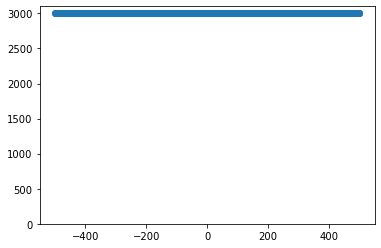

In [41]:

plt.plot(list(range(-500, 500)), phot_norm, 'o')
plt.ylim([0, 3100])

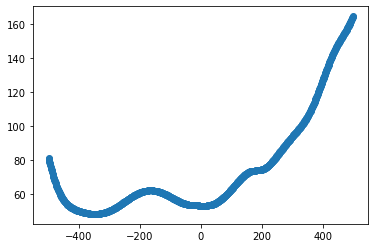

In [42]:
plt.plot(list(range(-500, 500)), crlbs_norm, 'o')

In [43]:
crlbs, phot, d_sum = test_psf(False, ix)

INITIATING CPU IMPLEMENTATION


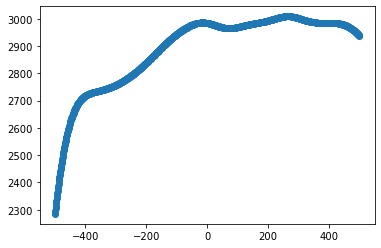

In [35]:
plt.plot(list(range(-500, 500)), phot, 'o')


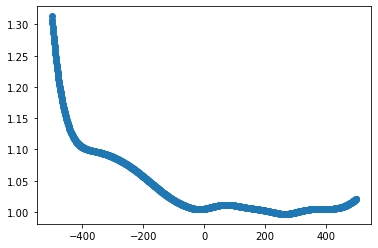

In [36]:
plt.plot(list(range(-500, 500)), np.array(phot_norm)/np.array(phot), 'o')


INITIATING CPU IMPLEMENTATION
4183. Z: 8.799999. sq: 1.028566 
Deriv sums: x: 6.662282, y: 0.107905 , z: 21.778610 
The factor is: 1.014484. Z: 8.760000. sq: 1.029178 
Deriv sums: x: 6.705255, y: 0.119458 , z: 22.173889 
The factor is: 1.014484. Z: 8.760000. sq: 1.029178 
Deriv sums: x: 6.705255, y: 0.119458 , z: 22.173889 
The factor is: 1.014792. Z: 8.719999. sq: 1.029802 
Deriv sums: x: 6.747873, y: 0.130994 , z: 22.572590 
The factor is: 1.014792. Z: 8.719999. sq: 1.029802 
Deriv sums: x: 6.747873, y: 0.130994 , z: 22.572590 
The factor is: 1.015104. Z: 8.680000. sq: 1.030437 
Deriv sums: x: 6.790749, y: 0.142507 , z: 22.974758 
The factor is: 1.015104. Z: 8.680000. sq: 1.030437 
Deriv sums: x: 6.790749, y: 0.142507 , z: 22.974758 
The factor is: 1.015422. Z: 8.639999. sq: 1.031082 
Deriv sums: x: 6.833322, y: 0.153991 , z: 23.380407 
The factor is: 1.015422. Z: 8.639999. sq: 1.031082 
Deriv sums: x: 6.833322, y: 0.153991 , z: 23.380407 
The factor is: 1.015746. Z: 8.600000. sq: 1.

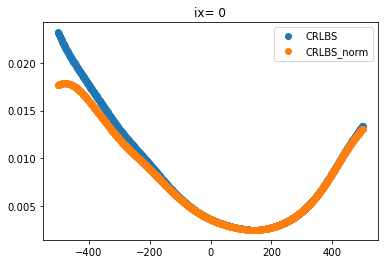

INITIATING CPU IMPLEMENTATION
, z: 26.750195 
The factor is: 1.018558. Z: 8.280001. sq: 1.037460 
Deriv sums: x: 7.209823, y: 0.254193 , z: 27.186964 
The factor is: 1.018558. Z: 8.280001. sq: 1.037460 
Deriv sums: x: 7.209823, y: 0.254193 , z: 27.186964 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The factor is: 1.019715. Z: 8.160000. sq: 1.039819 
Deriv sums: x: 7.330388, y: 0.285600 , z: 28.518101 
The factor is: 1.019715. Z: 8.160000. sq: 1.039819 
Deriv sums: x: 7.330388, y: 0.285600 , z: 28.518101 
The factor is: 1.020114. Z: 8.120001. sq: 1.040632 
Deriv sums: x: 7.369988, y: 0.295762 , z: 28.968771 
The facto

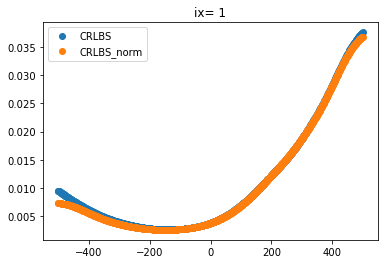

INITIATING CPU IMPLEMENTATION
eriv sums: x: 6.875944, y: 0.165429 , z: 23.789543 
The factor is: 1.016078. Z: 8.559999. sq: 1.032414 
Deriv sums: x: 6.918340, y: 0.176805 , z: 24.202129 
The factor is: 1.016078. Z: 8.559999. sq: 1.032414 
Deriv sums: x: 6.918340, y: 0.176805 , z: 24.202129 
The factor is: 1.016412. Z: 8.520000. sq: 1.033094 
Deriv sums: x: 6.960693, y: 0.188130 , z: 24.618158 
The factor is: 1.016412. Z: 8.520000. sq: 1.033094 
Deriv sums: x: 6.960693, y: 0.188130 , z: 24.618158 
The factor is: 1.016756. Z: 8.480000. sq: 1.033792 
Deriv sums: x: 7.002610, y: 0.199373 , z: 25.037666 
The factor is: 1.016756. Z: 8.480000. sq: 1.033792 
Deriv sums: x: 7.002610, y: 0.199373 , z: 25.037666 
The factor is: 1.017104. Z: 8.440001. sq: 1.034500 
Deriv sums: x: 7.044642, y: 0.210539 , z: 25.460608 
The factor is: 1.017104. Z: 8.440001. sq: 1.034500 
Deriv sums: x: 7.044642, y: 0.210539 , z: 25.460608 
The factor is: 1.017458. Z: 8.400000. sq: 1.035221 
Deriv sums: x: 7.086333, y

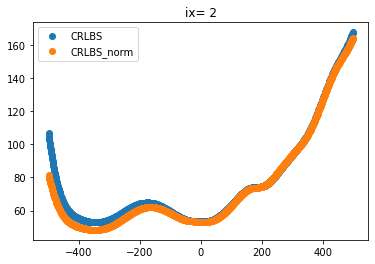

INITIATING CPU IMPLEMENTATION
20519. Z: 8.080000. sq: 1.041458 
Deriv sums: x: 7.408954, y: 0.305753 , z: 29.422819 
The factor is: 1.020519. Z: 8.080000. sq: 1.041458 
Deriv sums: x: 7.408954, y: 0.305753 , z: 29.422819 
The factor is: 1.020931. Z: 8.040001. sq: 1.042299 
Deriv sums: x: 7.447833, y: 0.315576 , z: 29.880350 
The factor is: 1.020931. Z: 8.040001. sq: 1.042299 
Deriv sums: x: 7.447833, y: 0.315576 , z: 29.880350 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.3

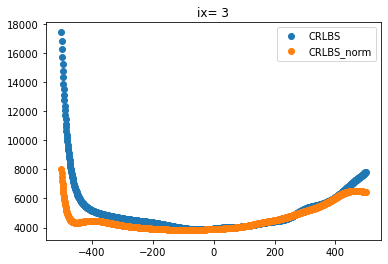

INITIATING CPU IMPLEMENTATION
6 , z: 25.887028 
The factor is: 1.017818. Z: 8.360001. sq: 1.035953 
Deriv sums: x: 7.127769, y: 0.232586 , z: 26.316797 
The factor is: 1.017818. Z: 8.360001. sq: 1.035953 
Deriv sums: x: 7.127769, y: 0.232586 , z: 26.316797 
The factor is: 1.018185. Z: 8.320000. sq: 1.036700 
Deriv sums: x: 7.168783, y: 0.243448 , z: 26.750195 
The factor is: 1.018185. Z: 8.320000. sq: 1.036700 
Deriv sums: x: 7.168783, y: 0.243448 , z: 26.750195 
The factor is: 1.018558. Z: 8.280001. sq: 1.037460 
Deriv sums: x: 7.209823, y: 0.254193 , z: 27.186964 
The factor is: 1.018558. Z: 8.280001. sq: 1.037460 
Deriv sums: x: 7.209823, y: 0.254193 , z: 27.186964 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The fac

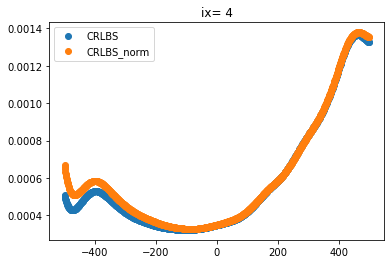

In [44]:
for ix in range(0, 5):

    crlbs_norm, phot_norm, d_norm = test_psf(True,ix)
    crlbs, phot, d = test_psf(False,ix)


    plt.plot(np.array(list(range(-500, 500))), crlbs, 'o')
    plt.plot(np.array(list(range(-500, 500))), crlbs_norm, 'o')
    plt.legend(['CRLBS', 'CRLBS_norm'])
    plt.title(f'ix= {ix}')
    plt.show()

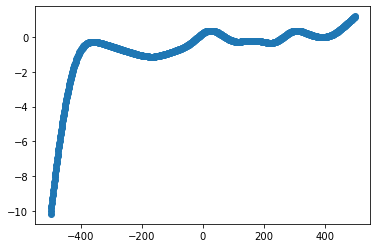

In [38]:
plt.plot(np.array(list(range(-500, 500))), d_sum, 'o')
#plt.plot(np.array(list(range(-500, 500))), d_norm, 'o')
# plt.legend(['d_sums', 'd_sum_norm'])

In [22]:
psf_norm = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
roi_size=None, roi_auto_center=None, normalize=True)

psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
roi_size=None, roi_auto_center=None, normalize=False)

INITIATING CPU IMPLEMENTATION
INITIATING CPU IMPLEMENTATION


In [23]:
xyz = (torch.tensor([60, 60, -500])).view(-1, 3)
photon_scale = 3000
photons = torch.ones((xyz.shape[0]))*photon_scale
bg = torch.zeros(im.shape[1], im.shape[2])


d_norm = psf_norm.derivative(xyz, photons, bg)[0][0,0,:,:]
d = psf.derivative(xyz, photons, bg)[0][0,0,:,:]

In [24]:
crlb = psf_norm.crlb(xyz, photons, bg)
crlb[0]

tensor([[1.7674e-02, 7.2910e-03, 8.1391e+01, 8.0209e+03, 6.7155e-04]])

In [25]:
sqd = ((d_norm - d)**2)
print(sqd.sum())

tensor(14.1949)


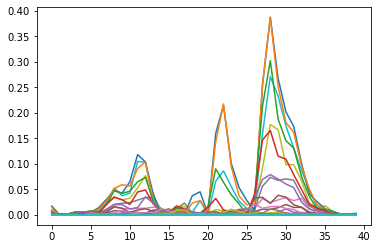

In [26]:
plt.plot(sqd);

In [27]:
sqdiffs = []
diffs = []

crlb_diffs = []

for z in range(-500, 500):
    xyz = (torch.tensor([60, 60, z])).view(-1, 3)
    photon_scale = 3000
    photons = torch.ones((xyz.shape[0]))*photon_scale
    im = psf.forward(xyz, photons);
    bg = torch.zeros(im.shape[1], im.shape[2])
    d_norm = psf_norm.derivative(xyz, photons, bg)[0][0,0,:,:]
    d = psf.derivative(xyz, photons, bg)[0][0,0,:,:]

    crlb_norm = psf_norm.crlb(xyz, photons, bg)[0][0,0]
    crlb = psf.crlb(xyz, photons, bg)[0][0,0]


    sqd = ((d_norm - d)**2)

    diff = (d_norm - d)

    sqdiffs.append(sqd.sum())
    diffs.append(diff.sum())

    crlb_diffs.append(crlb_norm - crlb)

The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.296159. Z: 47.879997. sq: 1.680028 
Deriv sums: x: -0.342825, y: -6.029962 , z: -242.862061 
The factor

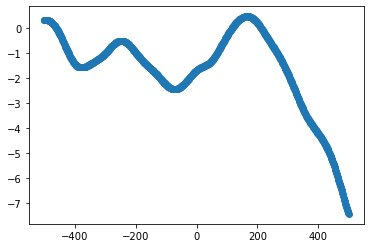

In [28]:
plt.plot(list(range(-500, 500)), np.array(diffs)*1, 'o')
plt.show()

In [29]:
crlbs_norm

type: name 'crlbs_norm' is not defined

In [ ]:
d = psf.derivative(xyz, photons, bg);


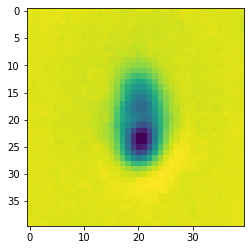

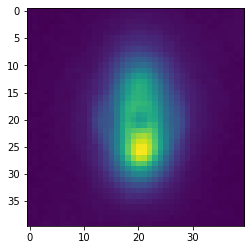

In [ ]:
plt.imshow(d[0][0, 2])
plt.show()
plt.imshow(psf.forward(xyz, photons)[0, 40:80, 40:80])
plt.show()

In [ ]:
xyz[0,2] = 500

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 39.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 33.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8., 32.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  6., 31.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  5., 30.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  4.,  2.,  4., 29.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  2.,  3.,  3., 29.],
        [ 0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  4., 28.],
        [ 0.,  0.,  0.,  1.,  2.,  2.,  

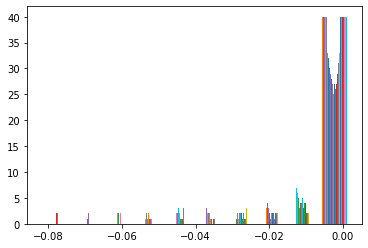

In [1]:
import numpy as np

10.643856189774725